In [1]:
from pycbc.inference import io, models
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

from pycbc.workflow import WorkflowConfigParser

In [2]:
# load the posterior file
fp = io.loadfile('./pycbc/srate4096-low20-high1024/result.hdf', 'r')
# get the config, the data, and PSDs from the file
# the config file:
cp = fp.read_config_file()
# the data
data = fp.read_data()
# the psds
psds = fp.read_psds()

In [3]:
# now let's load the model
model = models.read_from_config(cp, data=data, psds=psds)

In [4]:
# let's get the maximum likelihood point
samples = fp.read_samples(list(fp['samples'].keys()))
maxlidx = samples['loglikelihood'].argmax()
maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}

In [5]:
# get the loglikelihood of these points
model.update(**maxlparams)
model.loglikelihood

-324786.2898244053

In [6]:
# get the matched-filter SNR
print((2*model.loglr)**0.5)

13.280139139776418


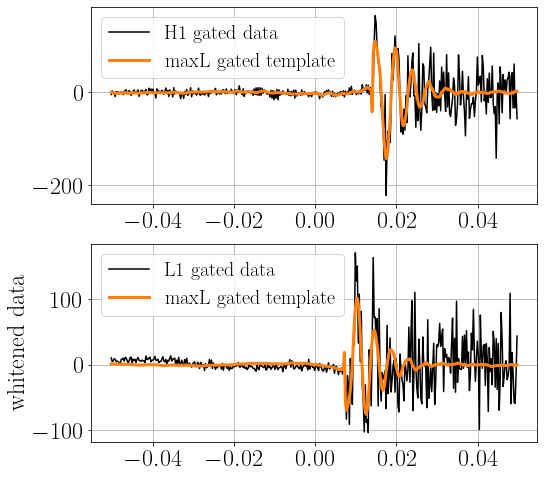

In [8]:
# get the gated, whitened maxL waveform and plot it against
# the whitened data
gated_wfs = model.get_gated_waveforms()
gated_data = model.get_gated_data()
# whiten them
gated_wfs = model.whiten(gated_wfs, 1)
gated_data = model.whiten(gated_data, 1)
# convert to the time domain
gated_wfs = {ifo: d.to_timeseries() for ifo, d in gated_wfs.items()}
gated_data = {ifo: d.to_timeseries() for ifo, d in gated_data.items()}

fig, axes = plt.subplots(nrows=2, figsize=(8,8))
for ii, ifo in enumerate(gated_wfs):
    ax = axes[ii]
    # we'll plot w.r.t. the geocentric end gate time
    t_gate_end = model.current_params['t_gate_end']
    d = gated_data[ifo].time_slice(t_gate_end-0.05, t_gate_end+0.05)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='black', label='{} gated data'.format(ifo))
    # plot the waveform
    d = gated_wfs[ifo].time_slice(t_gate_end-0.05, t_gate_end+0.05)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='C1', lw=3, label='maxL gated template')
    ax.legend()
    if ii == 2:
        ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)')
    if ii == 1:
        ax.set_ylabel('whitened data')
fig.show()

In [9]:
gated_wfs = model.get_gated_waveforms()

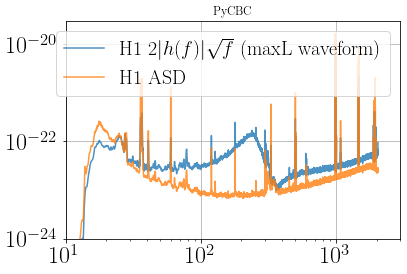

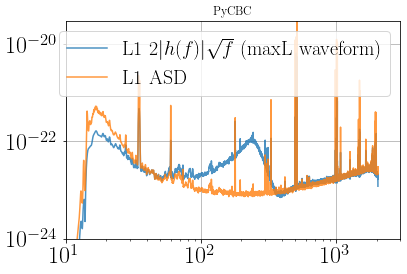

In [10]:
for ifo in ['H1','L1']:
    plt.figure()
    f = gated_wfs[ifo].sample_frequencies
    plt.loglog(f,2*abs(gated_wfs[ifo])*np.sqrt(f),alpha=0.8,label=str(ifo)+' $2|h(f)|\sqrt{f}$ (maxL waveform)')
    plt.loglog(psds[ifo].sample_frequencies,np.sqrt(psds[ifo]),alpha=0.8,label=str(ifo)+' ASD')
    plt.title('PyCBC')
    plt.xlim(10,3000)
    plt.ylim(1e-24,3e-20)
    plt.legend()

# 07.20: PSD studies 

In [66]:
cp = WorkflowConfigParser(['./pycbc/srate4096-low20-high1024/inference-GW150914_095045.ini'])

In [67]:
cp.sections()

['data',
 'sampler',
 'model',
 'variable_params',
 'static_params',
 'waveform_transforms-t_gate_start',
 'waveform_transforms-t_gate_end',
 'waveform_transforms-tc',
 'prior-final_mass',
 'prior-final_spin',
 'prior-amp220',
 'prior-phi220',
 'prior-absamp221',
 'waveform_transforms-amp221',
 'prior-phi221']

In [68]:
cp.remove_option('data','psd-inverse-length')

True

In [71]:
cp.get('data','sample-rate')

'4096'

In [79]:
import pycbc

In [77]:
pycbc.logging?

In [35]:
model2 = models.read_from_config(cp)

In [39]:
psd2 = model2.psds

(1e-46, 1e-44)

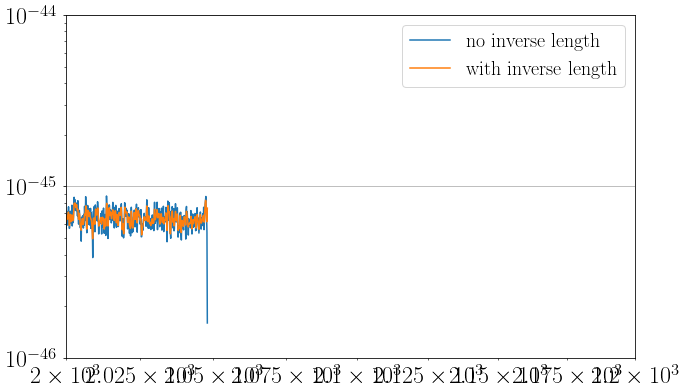

In [52]:
plt.loglog(psd2['H1'].sample_frequencies,psd2['H1'],label='no inverse length')
plt.loglog(psds['H1'].sample_frequencies,psds['H1'],label='with inverse length')
plt.xlim(2000,2200)
plt.legend()
plt.ylim(1e-46,1e-44)

# Ringdown PSD

In [57]:
from ringdb import Database

# Initialise the database in an empty folder you want your data stored
db = Database("./Data") 
db.initialize()

# Pick an event of your choosing 
event = db.event("GW150914")

In [58]:
# Query it for psds, posteriors and strain data for each detector 
psd_db = event.psd()

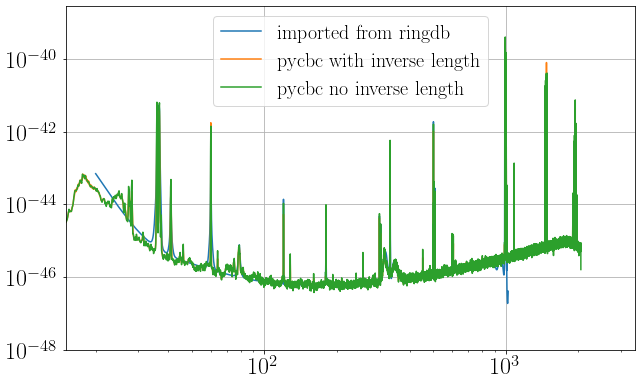

In [64]:
plt.loglog(psd_db['H1'].index,psd_db['H1'].values,label='imported from ringdb')
plt.loglog(psds['H1'].sample_frequencies,psds['H1'],label='pycbc with inverse length')
plt.loglog(psd2['H1'].sample_frequencies,psd2['H1'],label='pycbc no inverse length')
plt.xlim(15,)
plt.ylim(1e-48)
plt.legend()

# Ringdown SNR studies

In [11]:
import ringdown
import h5py
import arviz as az
from pylab import *

def rd_snr(L,hs,data=None,optimal=True, network=True) -> np.ndarray:
    '''
    L: cholesky factor
    hs: h strain
    data: raw data
    '''
    whs = linalg.solve(L, hs)
    opt_ifo_snrs = linalg.norm(whs, axis=1)
    if optimal:
        snrs = opt_ifo_snrs
    else:
        # whiten it with the Cholesky factors, so shape will remain (ifo, time)
        wdata = linalg.solve(L, data)
        # take inner product between whitened template and data, and normalize
        snrs = einsum('ijk,ij->ik', whs, wdata)/opt_ifo_snrs
    if network:
        # take norm across detectors
        return linalg.norm(snrs, axis=0)
    else:
        return snrs
    
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

In [16]:
fit = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])

srcpath = '/work/yifan.wang/more_ringdown/runs/ringdown-runs/numpyro/'
fit.result = az.from_netcdf('/work/yifan.wang/more_ringdown/runs/ringdown-runs/numpyro/srate16384-0p2s-32sdata.nc')
h_raw_strain = read_strain(srcpath+'H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain(srcpath+'L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'L1')
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
T=0.2
srate=16384
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)
fit.compute_acfs()

In [17]:
L = [a.iloc[:fit.n_analyze].cholesky for a in fit.acfs.values()]
hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
data = fit.analysis_data
data_dict = list(data.values())

In [19]:
optsnr = rd_snr(L,hs,data=None,optimal=True,network=True)
mfsnr = rd_snr(L,hs,data_dict,optimal=False,network=True)

In [20]:
A = fit.result.posterior.A.stack(samples=('chain','draw'))
phi = fit.result.posterior.phi.stack(samples=('chain','draw'))
M = fit.result.posterior.M.stack(samples=('chain','draw'))
chi = fit.result.posterior.chi.stack(samples=('chain','draw'))

In [21]:
i = np.argmax(mfsnr)
prefactor = np.sqrt(16*np.pi/5)
pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}

In [22]:
mfsnr[i]

12.931891956005002

In [23]:
pyring_par

{'Mf': array(66.67005, dtype=float32),
 'af': array(0.6310576, dtype=float32),
 'A2220': 6.4209056912267215,
 'A2221': 9.712598836033408,
 'phi2220': -1.0682567,
 'phi2221': 1.6183428}

In [30]:
i = np.argmax(mfsnr)
prefactor = np.sqrt(16*np.pi/5)
pycbc_par = {'final_mass': M[i].values,
                  'final_spin': chi[i].values,
                  'amp220': A[0][i].values*prefactor,
                  'absamp221': A[1][i].values*prefactor,
                  'amp221': A[1][i].values/A[0][i].values,
                  'phi220': -phi[0][i].values,
                  'phi221': -phi[1][i].values}

In [32]:
model.update(**pycbc_par)

In [34]:
model.current_params

{'final_mass': 66.67005157470703,
 'final_spin': 0.631057620048523,
 'amp220': 6.42090569122672e-21,
 'absamp221': 9.712598836033405e-21,
 'amp221': 1.5126525,
 'phi220': -1.0682567,
 'phi221': 1.6183428,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 222.0,
 'polarization': 0.82,
 'inclination': 3.14159265}

In [35]:
# get the loglikelihood of these points
model.loglikelihood

-324887.33264264563

In [36]:
# get the matched-filter SNR
print((2*model.loglr)**0.5)

(3.10667620193198e-16+5.073587264662708j)


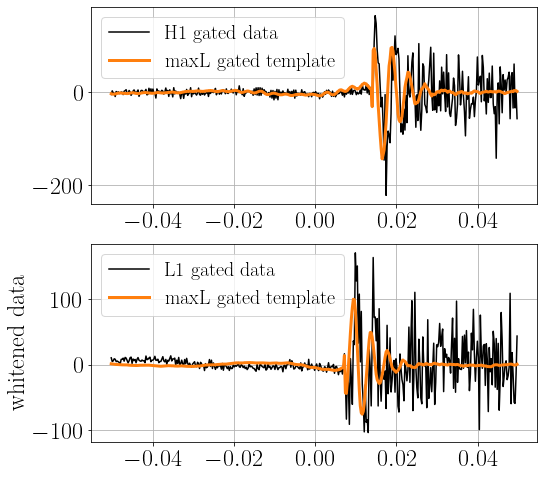

In [37]:
# get the gated, whitened maxL waveform and plot it against
# the whitened data
gated_wfs = model.get_gated_waveforms()
gated_data = model.get_gated_data()
# whiten them
gated_wfs = model.whiten(gated_wfs, 1)
gated_data = model.whiten(gated_data, 1)
# convert to the time domain
gated_wfs = {ifo: d.to_timeseries() for ifo, d in gated_wfs.items()}
gated_data = {ifo: d.to_timeseries() for ifo, d in gated_data.items()}

fig, axes = plt.subplots(nrows=2, figsize=(8,8))
for ii, ifo in enumerate(gated_wfs):
    ax = axes[ii]
    # we'll plot w.r.t. the geocentric end gate time
    t_gate_end = model.current_params['t_gate_end']
    d = gated_data[ifo].time_slice(t_gate_end-0.05, t_gate_end+0.05)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='black', label='{} gated data'.format(ifo))
    # plot the waveform
    d = gated_wfs[ifo].time_slice(t_gate_end-0.05, t_gate_end+0.05)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='C1', lw=3, label='maxL gated template')
    ax.legend()
    if ii == 2:
        ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)')
    if ii == 1:
        ax.set_ylabel('whitened data')
fig.show()